In [75]:
import pandas as pd
import numpy as np

# fetch the MNIST dataset
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [76]:
# look at datas and targets

X,y = mnist["data"],mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


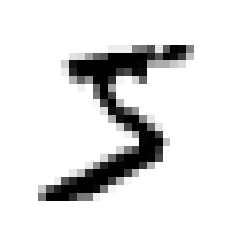

In [77]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.loc[0]
some_digit_image = np.array(some_digit).reshape(28,28)

plt.imshow(some_digit_image,cmap="binary")
plt.axis("off")
plt.show()

In [78]:
y[0]

'5'

In [79]:
y = y.astype(np.uint8)
y

0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 70000, dtype: uint8

In [80]:
X_train,X_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]

In [81]:
# training a binary classifier
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [82]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

sgd_clf.predict([some_digit])

array([ True])

In [84]:
# use cross_val_value function by yourself
# StratifiedKFold 用于分层抽样

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3,random_state=42,shuffle=True)

for train_index,test_index in skfolds.split(X_train,y_train_5):
    # clone 已经训练好的 sgd_clf
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5.iloc[test_index]

    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.9669
0.91625
0.96785


In [85]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv = 3,scoring="accuracy")


array([0.95035, 0.96035, 0.9604 ])

In [ ]:
# 将每个照片都分类成not-5的类型
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self,X,y = None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)

In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv = 3,scoring="accuracy")

In [86]:
# 构建confusion matrix
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv = 3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [87]:
y_train_perfect_predictions = y_train_5 #pretend we reached perfection
confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [88]:
from sklearn.metrics import precision_score,recall_score
precision_score(y_train_5,y_train_pred)

0.8370879772350012

In [89]:
recall_score(y_train_5,y_train_pred)

0.6511713705958311

In [90]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7325171197343846

In [91]:
# how to set your own sgd threshold
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [92]:
threshold = 800
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

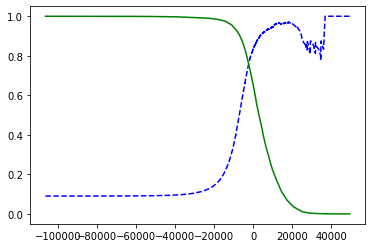

In [94]:
# sgd 获取预测分数 method = "decision function"
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv = 3,
                             method="decision_function")
from sklearn.metrics import precision_recall_curve
precisions,recalls,thresholds = precision_recall_curve(y_train_5,y_scores)

# use the plt to plot precision and recall as functions of the threshold value
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds,precisions[:-1],"b--",label = "Precision")
    plt.plot(thresholds,recalls[:-1],"g-",label = "Recall")
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

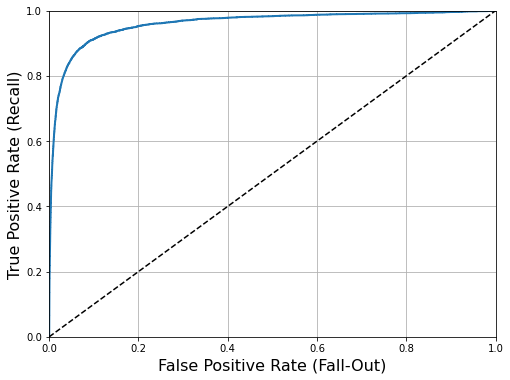

In [95]:
from sklearn.metrics import roc_curve
fpr,tpr,thresholds = roc_curve(y_train_5,y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
plt.show

In [96]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)


0.9604938554008616

In [97]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method="predict_proba")

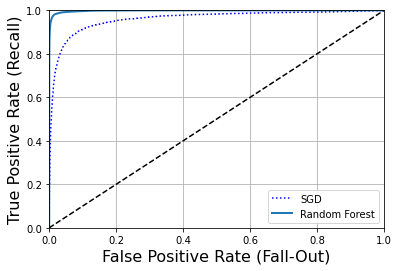

In [99]:
y_scores_forest = y_probas_forest[:,1] #score = proba of positive
fpr_forest,tpr_forest,thresholds_forest = roc_curve(y_train_5,y_scores_forest)

plt.plot(fpr,tpr,"b:",label = "SGD")
plot_roc_curve(fpr_forest,tpr_forest,"Random Forest")
plt.legend(loc = "lower right")
plt.show()

In [100]:
roc_auc_score(y_train_5,y_scores_forest)


0.9983436731328145